## 导入python库

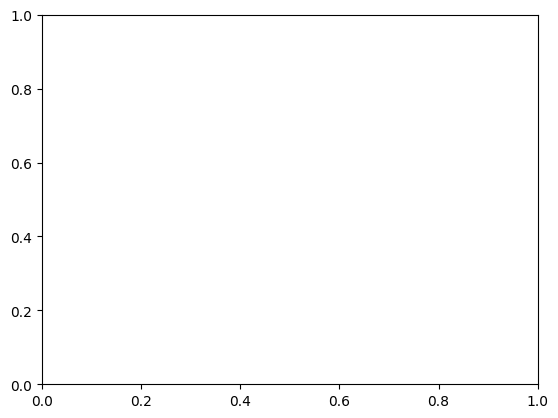

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('default')  # 设置画图的风格
import shap


from EIDG import EIDG
from vehicle_related import Vehicle
from vehicle_related import plot_vehicle
from vehicle_related import calculate_acceleration


import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## IDM 模拟车辆跟车过程，并产生数据

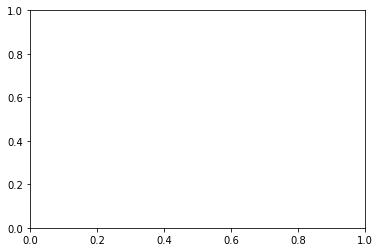

In [2]:

# 创建初始图
fig, ax = plt.subplots()
plt.ion()  # 打开交互模式
# 定义前视范围和后视范围
front_view = 80  # 前视范围，单位：米
rear_view = 80  # 后视范围，单位：米

# 循环调用fcn函数
def plot_vehicle(s1, s2):
    ax.clear()  # 清除前一次迭代的图
    # 计算x轴范围
    x_min = s1 - front_view
    x_max = s1 + rear_view

    # 绘制道路
    road_length = front_view + rear_view  # 道路长度，单位：米
    road_width = 3.5  # 道路宽度，单位：米
    ax.add_patch(plt.Rectangle((x_min, 0), road_length, road_width, edgecolor='k', facecolor='w'))

    # 定义车辆的绝对尺寸
    car_length = 4  # 车辆的长度，单位：米
    car_width = 2  # 车辆的宽度，单位：米

    # 绘制第一辆车
    car1_center = s1  # 第一辆车的质心位置，单位：米
    ax.add_patch(plt.Rectangle((car1_center - car_length / 2, (road_width - car_width) / 2), car_length, car_width,
                               edgecolor='r', facecolor='none'))

    # 绘制第二辆车
    car2_center = s2  # 第二辆车的质心位置，单位：米
    ax.add_patch(plt.Rectangle((car2_center - car_length / 2, (road_width - car_width) / 2), car_length, car_width,
                               edgecolor='b', facecolor='none'))

    # 设置坐标轴
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([0, road_width])

    # 添加标签和标题
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Width (m)')
    ax.set_title('Road with Cars')

    plt.pause(0.2)  # 等待一段时间以便查看图像


# 创建两辆车
car1 = Vehicle(initial_speed=0, initial_position=0)
car2 = Vehicle(initial_speed=10, initial_position=30)

# 模拟时间步长和总模拟时间
time_step = 0.05  # 时间步长（秒）
total_simulation_time = 20  # 总模拟时间（秒）

# 列表用于存储车辆状态
s_list = []
v_list = []
delta_v_list = []
acc_list = []
for t in np.arange(0, total_simulation_time, time_step):
    # 计算两辆车的加速度
    if (car2.position - car1.position) < 4:
        print("crash")
        break

    # plot_vehicle(car1.position, car2.position)

    s = car2.position - car1.position
    v = car1.speed
    delta_v = car1.speed - car2.speed

    car1_acceleration = calculate_acceleration(s, v, delta_v)
    # 更新车辆状态
    car1.update(time_step, car1_acceleration)
    car2.update(time_step, 0)

    # 保存车辆速度和位置
    s_list.append(s)
    v_list.append(v)
    delta_v_list.append(delta_v)
    acc_list.append(car1_acceleration)

# 关闭交互模式
plt.ioff()
plt.show()

In [3]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# 假设您已经有了数据 v、s、delta_v 和 a_v
# 假设数据已经通过数据处理和特征工程
s = np.array(s_list)
v = np.array(v_list)
delta_v= np.array(delta_v_list)
# 数据预处理
X = np.column_stack((s, v, delta_v))
y = np.array(acc_list)

##  XGBoost模型训练和归因

### 模型训练

XGBoost R-squared (R2): 0.9938289671487315


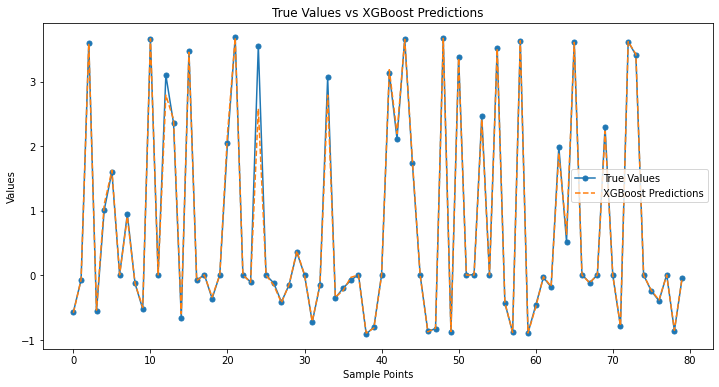

In [4]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用XGBoost进行回归
xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb_reg.fit(X_train, y_train)

# 计算XGBoost的预测输出
xgb_predictions = xgb_reg.predict(X_test)

# 计算R-squared（R2）来衡量模型准确性
xgb_r2 = r2_score(y_test, xgb_predictions)

print("XGBoost R-squared (R2):", xgb_r2)

# 绘制真实值和XGBoost预测值的曲线对比
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='True Values', marker='o', markersize=5)
plt.plot(range(len(y_test)), xgb_predictions, label='XGBoost Predictions', linestyle='--')
plt.xlabel('Sample Points')
plt.ylabel('Values')
plt.legend()
plt.title('True Values vs XGBoost Predictions')
plt.show()

In [5]:
import joblib
joblib.dump(xgb_reg, 'xgb_regression_model_start.pkl')

['xgb_regression_model_start.pkl']

### 归因（EIDG方法，正定，多基值）

#### 特征归因值计算

In [6]:
eidg_instance = EIDG(x_baselines=X_train, model = xgb_reg.predict,steps=100, h=0.1, m=10, pos=True)
explainer_xgb_eidg_values = eidg_instance.integrated_gradients(X_train)

EIDG运行时间： 0.13189291954040527 秒


#### 归因值和特征值关系可视化

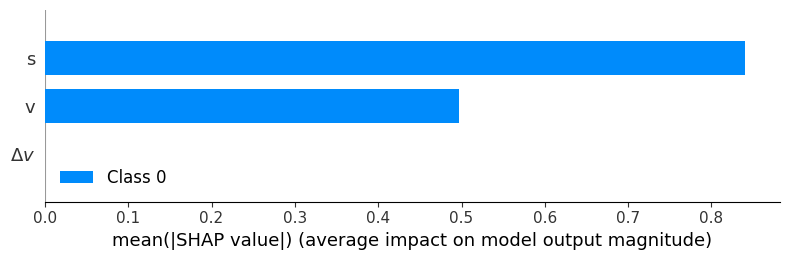

In [9]:
shap.initjs()
%config InlineBackend.figure_format = 'png'
plt.style.use('default')  # 设置画图的风格
featurename = ["s","v",r"$\Delta v$"]
shap.summary_plot(explainer_xgb_eidg_values, X_train, feature_names=featurename, show=True)

### 归因（EIDG方法，随机，多基值）

#### 特征归因值计算

In [10]:
eidg_instance_RS = EIDG(x_baselines=X_train, model = xgb_reg.predict,steps=100, h=0.1, m=10, pos=False)
explainer_xgb_eidg_values_RS = eidg_instance_RS.integrated_gradients(X_train)

EIDG运行时间： 0.21160387992858887 秒


#### 归因值和特征值关系可视化

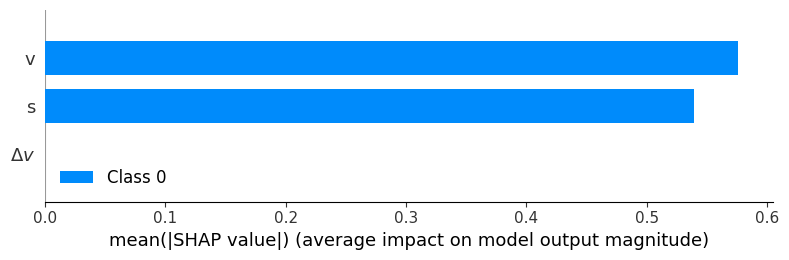

In [11]:
shap.initjs()
%config InlineBackend.figure_format = 'png'
plt.style.use('default')  # 设置画图的风格
featurename = ["s","v",r"$\Delta v$"]
shap.summary_plot(explainer_xgb_eidg_values_RS, X_train, feature_names=featurename, show=True)

### 归因（kernelSHAP方法）

#### 特征归因值计算

In [12]:

explainer_xgb = shap.KernelExplainer(xgb_reg.predict, eidg_instance.x_baselines)
# 计算归因值
explainer_xgb_shap_values = explainer_xgb.shap_values(X_train)

  0%|          | 0/320 [00:00<?, ?it/s]

#### 归因值和特征值关系可视化

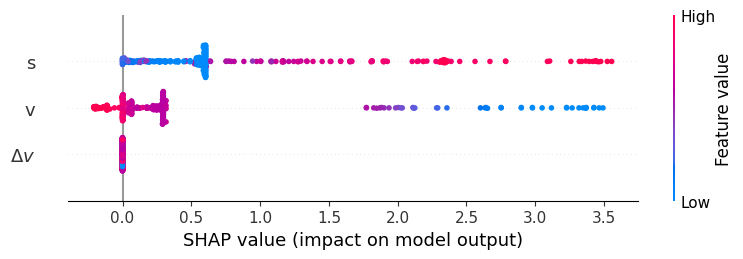

In [13]:
shap.initjs()
%config InlineBackend.figure_format = 'png'
plt.style.use('default')  # 设置画图的风格
featurename = ["s","v",r"$\Delta v$"]
shap.summary_plot(explainer_xgb_shap_values, X_train, feature_names=featurename, show=True)

##  MLP模型训练和归因

MLPRegressor R-squared (R2): 0.9991605435943715


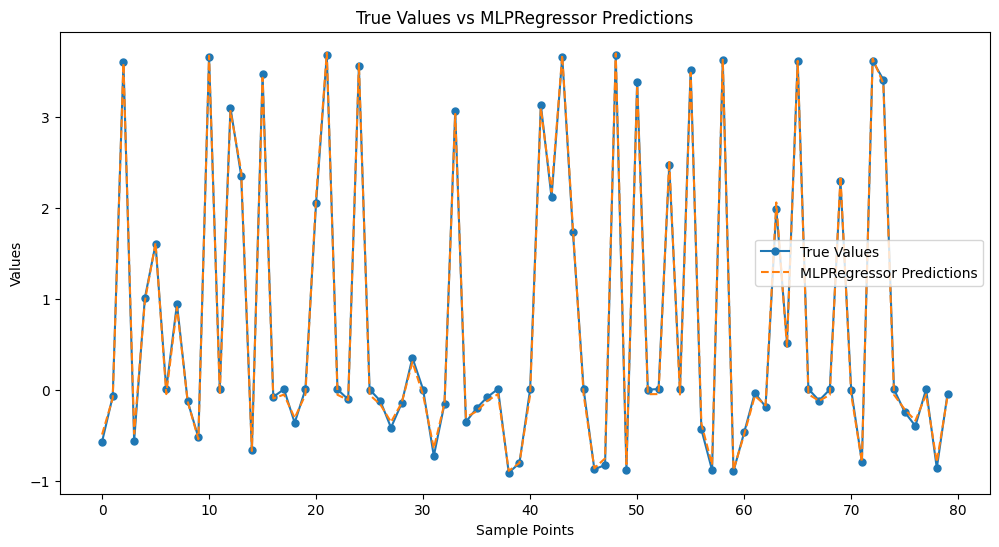

In [14]:
# 创建 Scikit-learn 的 MLPRegressor 模型
from sklearn.neural_network import MLPRegressor
mlp_reg = MLPRegressor(hidden_layer_sizes=(128, 128), max_iter=1000, random_state=42)

# 训练模型
mlp_reg.fit(X_train, y_train)

# 计算 MLPRegressor 模型的预测输出
mlp_predictions = mlp_reg.predict(X_test)

# 计算 R-squared（R2）来衡量模型准确性
mlp_r2 = r2_score(y_test, mlp_predictions)

print("MLPRegressor R-squared (R2):", mlp_r2)

# 绘制真实值和 MLPRegressor 模型的预测值的曲线对比
plt.figure(figsize=(12, 6))
sample_points = range(len(y_test))
plt.plot(sample_points, y_test, label='True Values', marker='o', markersize=5)
plt.plot(sample_points, mlp_predictions, label='MLPRegressor Predictions', linestyle='--')
plt.xlabel('Sample Points')
plt.ylabel('Values')
plt.legend()
plt.title('True Values vs MLPRegressor Predictions')
plt.show()

In [15]:
import joblib

# 将模型保存到文件
joblib.dump(mlp_reg, 'mlp_regression_model_start.pkl')

['mlp_regression_model_start.pkl']

### 归因（EIDG方法，正定，多基值）

In [16]:
eidg_instance_mlp = EIDG(x_baselines=X_train, model = mlp_reg.predict,steps=5, h=0.1, m=10, pos=True)

In [17]:
explainer_mlp_eidg_values = eidg_instance_mlp.integrated_gradients(X_train)

EIDG运行时间： 0.5921039581298828 秒


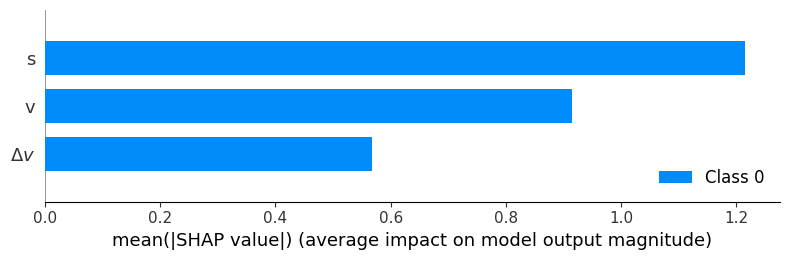

In [18]:
shap.initjs()
%config InlineBackend.figure_format = 'png'
plt.style.use('default')  # 设置画图的风格
featurename = ["s","v",r"$\Delta v$"]
shap.summary_plot(explainer_mlp_eidg_values, X_train, feature_names=featurename, show=True)

In [19]:
import shap
explainer_mlp = shap.KernelExplainer(mlp_reg.predict, eidg_instance_mlp.x_baselines)

In [20]:
# 计算归因值
explainer_mlp_shap_values = explainer_mlp.shap_values(X_train)

In [21]:
RS_explainer_mlp = shap.KernelExplainer(mlp_reg.predict, X[20:25,:])
# 计算归因值
RS_explainer_mlp_shap_values = RS_explainer_mlp.shap_values(X_train)